In [2]:
import pyspark as ps

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import json
import matplotlib.pyplot as plt
import scipy.stats as stats

# Always make it pretty.
plt.style.use('ggplot')

In [8]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('lecture')
         .getOrCreate()
        )

In [9]:
sc = spark.sparkContext
sc

<SparkContext master=local[4] appName=lecture>

In [10]:
name_basics_path = 'IMDb_datasets/name.basics.tsv'
title_akas_path = 'IMDb_datasets/title.akas.tsv'
title_basics_path = 'IMDb_datasets/title.basics.tsv'
title_crew_path = 'IMDb_datasets/title.crew.tsv'
title_episode_path = 'IMDb_datasets/title.episode.tsv'
title_principals_path = 'IMDb_datasets/title.principals.tsv'
title_ratings_path = 'IMDb_datasets/title.ratings.tsv'

In [11]:
rdd_name_basics_raw = sc.textFile(name_basics_path)
rdd_title_akas_raw = sc.textFile(title_akas_path)
rdd_title_basics_raw = sc.textFile(title_basics_path)
rdd_title_crew_raw = sc.textFile(title_crew_path)
rdd_title_episode_raw = sc.textFile(title_episode_path)
rdd_title_principals_raw = sc.textFile(title_principals_path)
rdd_ntitle_ratings_raw = sc.textFile(title_ratings_path)

In [12]:
def transform_to_df(path):
    return spark.read.csv(path,
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep="\t",           # char for separation
                         inferSchema=True)  # do we infer schema or not ?

In [13]:
name_basics_df  = transform_to_df(name_basics_path)
title_akas_df   = transform_to_df(title_akas_path)
title_basics_df = transform_to_df(title_basics_path)
title_crew_df   = transform_to_df(title_crew_path)
title_episode_df= transform_to_df(title_episode_path)
title_principals_df = transform_to_df(title_principals_path)
title_ratings_df= transform_to_df(title_ratings_path)

In [10]:
name_basics_df.printSchema()
name_basics_df.show(5)

root
 |-- nconst: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- birthYear: string (nullable = true)
 |-- deathYear: string (nullable = true)
 |-- primaryProfession: string (nullable = true)
 |-- knownForTitles: string (nullable = true)

+---------+---------------+---------+---------+--------------------+--------------------+
|   nconst|    primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+---------------+---------+---------+--------------------+--------------------+
|nm0000001|   Fred Astaire|     1899|     1987|soundtrack,actor,...|tt0072308,tt00504...|
|nm0000002|  Lauren Bacall|     1924|     2014|  actress,soundtrack|tt0071877,tt01170...|
|nm0000003|Brigitte Bardot|     1934|       \N|actress,soundtrac...|tt0049189,tt00573...|
|nm0000004|   John Belushi|     1949|     1982|actor,writer,soun...|tt0078723,tt00779...|
|nm0000005| Ingmar Bergman|     1918|     2007|writer,director,a...|tt0050976,tt00839...|
+---------+-----

In [11]:
title_akas_df.printSchema()
title_akas_df.show(5)

root
 |-- titleId: string (nullable = true)
 |-- ordering: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- region: string (nullable = true)
 |-- language: string (nullable = true)
 |-- types: string (nullable = true)
 |-- attributes: string (nullable = true)
 |-- isOriginalTitle: string (nullable = true)

+---------+--------+--------------------+------+--------+-----------+----------+---------------+
|  titleId|ordering|               title|region|language|      types|attributes|isOriginalTitle|
+---------+--------+--------------------+------+--------+-----------+----------+---------------+
|tt0000001|       1|Carmencita - span...|    HU|      \N|imdbDisplay|        \N|              0|
|tt0000001|       2|          Καρμενσίτα|    GR|      \N|         \N|        \N|              0|
|tt0000001|       3|          Карменсита|    RU|      \N|         \N|        \N|              0|
|tt0000001|       4|          Carmencita|    US|      \N|         \N|        \N|           

In [12]:
title_basics_df.printSchema()
title_basics_df.show(5)

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: integer (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation

In [13]:
title_crew_df.printSchema()
title_crew_df.show(5)

root
 |-- tconst: string (nullable = true)
 |-- directors: string (nullable = true)
 |-- writers: string (nullable = true)

+---------+---------+-------+
|   tconst|directors|writers|
+---------+---------+-------+
|tt0000001|nm0005690|     \N|
|tt0000002|nm0721526|     \N|
|tt0000003|nm0721526|     \N|
|tt0000004|nm0721526|     \N|
|tt0000005|nm0005690|     \N|
+---------+---------+-------+
only showing top 5 rows



In [14]:
title_episode_df.printSchema()
title_episode_df.show(5)

root
 |-- tconst: string (nullable = true)
 |-- parentTconst: string (nullable = true)
 |-- seasonNumber: string (nullable = true)
 |-- episodeNumber: string (nullable = true)

+---------+------------+------------+-------------+
|   tconst|parentTconst|seasonNumber|episodeNumber|
+---------+------------+------------+-------------+
|tt0041951|   tt0041038|           1|            9|
|tt0042816|   tt0989125|           1|           17|
|tt0042889|   tt0989125|          \N|           \N|
|tt0043426|   tt0040051|           3|           42|
|tt0043631|   tt0989125|           2|           16|
+---------+------------+------------+-------------+
only showing top 5 rows



In [15]:
title_principals_df.printSchema()
title_principals_df.show(5)

root
 |-- tconst: string (nullable = true)
 |-- ordering: integer (nullable = true)
 |-- nconst: string (nullable = true)
 |-- category: string (nullable = true)
 |-- job: string (nullable = true)
 |-- characters: string (nullable = true)

+---------+--------+---------+---------------+--------------------+-----------+
|   tconst|ordering|   nconst|       category|                 job| characters|
+---------+--------+---------+---------------+--------------------+-----------+
|tt0000001|       1|nm1588970|           self|                  \N|["Herself"]|
|tt0000001|       2|nm0005690|       director|                  \N|         \N|
|tt0000001|       3|nm0374658|cinematographer|director of photo...|         \N|
|tt0000002|       1|nm0721526|       director|                  \N|         \N|
|tt0000002|       2|nm1335271|       composer|                  \N|         \N|
+---------+--------+---------+---------------+--------------------+-----------+
only showing top 5 rows



In [16]:
title_ratings_df.printSchema()
title_ratings_df.show(5)

root
 |-- tconst: string (nullable = true)
 |-- averageRating: double (nullable = true)
 |-- numVotes: integer (nullable = true)

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.8|    1504|
|tt0000002|          6.3|     183|
|tt0000003|          6.6|    1150|
|tt0000004|          6.3|     112|
|tt0000005|          6.2|    1849|
+---------+-------------+--------+
only showing top 5 rows



# Clean DATA

In [17]:
movies_df = title_basics_df[title_basics_df['titleType']=='movie']
movies_df.show(5)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000009|    movie|          Miss Jerry|          Miss Jerry|      0|     1894|     \N|            45|             Romance|
|tt0000147|    movie|The Corbett-Fitzs...|The Corbett-Fitzs...|      0|     1897|     \N|            20|Documentary,News,...|
|tt0000335|    movie|Soldiers of the C...|Soldiers of the C...|      0|     1900|     \N|            \N|     Biography,Drama|
|tt0000502|    movie|            Bohemios|            Bohemios|      0|     1905|     \N|           100|                  \N|
|tt0000574|    movie|The Story of the ...|The Story of the ...|      0|     1906|     \N|            70|Biography,Crim

# 1. movies_df_raw

In [18]:
movies_df_raw1 = title_akas_df.join(title_basics_df, title_akas_df['titleId'] == title_basics_df['tconst']).drop('tconst')
movies_df_raw1.printSchema()
movies_df_raw1.show(3)

root
 |-- titleId: string (nullable = true)
 |-- ordering: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- region: string (nullable = true)
 |-- language: string (nullable = true)
 |-- types: string (nullable = true)
 |-- attributes: string (nullable = true)
 |-- isOriginalTitle: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: integer (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)

+---------+--------+--------------------+------+--------+--------+----------+---------------+---------+--------------------+--------------------+-------+---------+-------+--------------+---------------+
|  titleId|ordering|               title|region|language|   types|attributes|isOriginalTitle|titleType|        primaryTitle|       origi

In [19]:
movies_df_raw2 = movies_df_raw1.join(title_crew_df, movies_df_raw1['titleId'] == title_crew_df['tconst']).drop('tconst')
movies_df_raw2.printSchema()
movies_df_raw2.show(3)

root
 |-- titleId: string (nullable = true)
 |-- ordering: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- region: string (nullable = true)
 |-- language: string (nullable = true)
 |-- types: string (nullable = true)
 |-- attributes: string (nullable = true)
 |-- isOriginalTitle: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: integer (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- directors: string (nullable = true)
 |-- writers: string (nullable = true)

+---------+--------+--------------------+------+--------+--------+----------+---------------+---------+--------------------+--------------------+-------+---------+-------+--------------+---------------+---------+-------+
|  titleId|ordering|               tit

In [20]:
movies_df_raw3 = movies_df_raw2.join(title_ratings_df, movies_df_raw2['titleId'] == title_ratings_df['tconst']).drop('tconst')
movies_df_raw3.printSchema()
movies_df_raw3.show(3)

root
 |-- titleId: string (nullable = true)
 |-- ordering: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- region: string (nullable = true)
 |-- language: string (nullable = true)
 |-- types: string (nullable = true)
 |-- attributes: string (nullable = true)
 |-- isOriginalTitle: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: integer (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- directors: string (nullable = true)
 |-- writers: string (nullable = true)
 |-- averageRating: double (nullable = true)
 |-- numVotes: integer (nullable = true)

+---------+--------+--------------------+------+--------+--------+----------+---------------+---------+--------------------+--------------------+-------+---------+-------+--

In [21]:
from pyspark.sql import functions as F

In [22]:
movies_df_raw4 = movies_df_raw3.filter((movies_df_raw3['titleType'] == 'tvMovie')|(movies_df_raw3['titleType']=='movie'))
movies_df_raw4.show(5)
movies_count = movies_df_raw4.groupby('titleType').agg(F.count("titleType"))
movies_count.show()

+---------+--------+--------------------+------+--------+--------+----------+---------------+---------+--------------------+--------------------+-------+---------+-------+--------------+-----------------+---------+-------------------+-------------+--------+
|  titleId|ordering|               title|region|language|   types|attributes|isOriginalTitle|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|           genres|directors|            writers|averageRating|numVotes|
+---------+--------+--------------------+------+--------+--------+----------+---------------+---------+--------------------+--------------------+-------+---------+-------+--------------+-----------------+---------+-------------------+-------------+--------+
|tt0004272|       1|Lucille Love, la ...|    VE|      \N|      \N|        \N|              0|    movie|Lucille Love: The...|Lucille Love: The...|      0|     1914|     \N|           300|           Action|nm0285643|nm0192062,nm

# 2. cast_crew_df_raw

In [23]:
cast_crew_df_raw1 = name_basics_df.join(title_principals_df, name_basics_df['nconst'] == title_principals_df['nconst']).drop(title_principals_df['nconst'])
cast_crew_df_raw1.printSchema()
cast_crew_df_raw1.show(2)

root
 |-- nconst: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- birthYear: string (nullable = true)
 |-- deathYear: string (nullable = true)
 |-- primaryProfession: string (nullable = true)
 |-- knownForTitles: string (nullable = true)
 |-- tconst: string (nullable = true)
 |-- ordering: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- job: string (nullable = true)
 |-- characters: string (nullable = true)

+---------+--------------+---------+---------+--------------------+--------------------+---------+--------+--------+---+--------------------+
|   nconst|   primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|   tconst|ordering|category|job|          characters|
+---------+--------------+---------+---------+--------------------+--------------------+---------+--------+--------+---+--------------------+
|nm0000086|Louis de Funès|     1914|     1983|actor,writer,soun...|tt0079200,tt00697...|tt0043398|       1|   acto

In [26]:
cast_crew_df_raw1_count = cast_crew_df_raw1.groupby('primaryName').agg(F.count("primaryName"))
cast_crew_df_raw1_count.show()

+--------------------+------------------+
|         primaryName|count(primaryName)|
+--------------------+------------------+
|     Acharya Athreya|                31|
|       Sidiki Bakaba|                23|
|     Vincenzo Cesano|                 1|
|             Chandni|                63|
|          Giulia Gam|               793|
|           S. Gergel|                 1|
| Vittorio Musy Glori|                 2|
|          Ivan Hajtl|                25|
|     Adrian Johnston|               192|
|        John Mauceri|                16|
|José María Paolan...|                23|
|         José Pelayo|                 1|
|  Valentina Telegina|                14|
|     Laura Treadwell|                 1|
|         Doug Walker|              1596|
|        Yuri Zhdanov|                 3|
|    David A. Hurwitz|                 2|
|          Hans Frank|                10|
|Christopher Zucke...|                 7|
|        Craig Coutee|                 1|
+--------------------+------------

# spark sql

In [24]:
movies_df_raw4.createOrReplaceTempView('moives_sql')
cast_crew_df_raw1.createOrReplaceTempView('cast_crew_sql')

# check duplicate data 

In [25]:
temp_movie_all = spark.sql("SELECT COUNT(titleId) FROM moives_sql") 
temp_movie = spark.sql("SELECT COUNT(DISTINCT titleId) FROM moives_sql") 

In [28]:
temp_movie_all.show()
temp_movie.show()

+--------+
|count(1)|
+--------+
| 1357687|
+--------+



+-----------------------+
|count(DISTINCT titleId)|
+-----------------------+
|                 271981|
+-----------------------+



In [31]:
271981/1357687

0.20032673215549682

In [32]:
temp_movie_id1 = spark.sql("SELECT * FROM moives_sql where titleId= 'tt0004272'") 
temp_movie_id1.show()

+---------+--------+--------------------+------+--------+--------+----------+---------------+---------+--------------------+--------------------+-------+---------+-------+--------------+------+---------+-------------------+-------------+--------+
|  titleId|ordering|               title|region|language|   types|attributes|isOriginalTitle|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|genres|directors|            writers|averageRating|numVotes|
+---------+--------+--------------------+------+--------+--------+----------+---------------+---------+--------------------+--------------------+-------+---------+-------+--------------+------+---------+-------------------+-------------+--------+
|tt0004272|       1|Lucille Love, la ...|    VE|      \N|      \N|        \N|              0|    movie|Lucille Love: The...|Lucille Love: The...|      0|     1914|     \N|           300|Action|nm0285643|nm0192062,nm0285643|          5.8|       9|
|tt0004272| 

In [35]:
temp_0 = spark.sql("SELECT count(nconst) FROM cast_crew_sql")
temp_0.show()

+-------------+
|count(nconst)|
+-------------+
|     33871367|
+-------------+



In [34]:
temp_1 = spark.sql("SELECT count(DISTINCT nconst) FROM cast_crew_sql")
temp_1.show()

+----------------------+
|count(DISTINCT nconst)|
+----------------------+
|               3716077|
+----------------------+



In [36]:
3716077/33871367

0.10971145628695765

# 3. join movies and cast/crew

In [37]:
movies_cast_crew_df_raw = movies_df_raw4.join(cast_crew_df_raw1, movies_df_raw4['titleId']==cast_crew_df_raw1['tconst']).drop(cast_crew_df_raw1['tconst'])

In [38]:
movies_cast_crew_df_raw.printSchema()

root
 |-- titleId: string (nullable = true)
 |-- ordering: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- region: string (nullable = true)
 |-- language: string (nullable = true)
 |-- types: string (nullable = true)
 |-- attributes: string (nullable = true)
 |-- isOriginalTitle: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: integer (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- directors: string (nullable = true)
 |-- writers: string (nullable = true)
 |-- averageRating: double (nullable = true)
 |-- numVotes: integer (nullable = true)
 |-- nconst: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- birthYear: string (nullable = true)
 |-- deathYear: string (nullable = true)
 |-- primar

In [39]:
movies_cast_crew_df_raw.createOrReplaceTempView('movies_cast_crew_sql')

## Data 1:  genres

In [ ]:
movies_over_time_df = movies_cast_crew_df_raw['titleId','title','region','genres','startYear','endYear']

In [ ]:
movies_over_time_df.show(10)

In [ ]:
item_num = movies_over_time_df.groupby('titleId').agg(F.count("titleId"))
item_num.show()

In [ ]:
movies_genres = spark.sql("SELECT DISTINCT titleId, genres, startYear FROM moives_sql")

In [ ]:
## movies_genres.show()

In [ ]:
movies_genres_df = movies_genres.toPandas()

## Data 2:  cast_age

In [53]:
movies_cast_df = spark.sql("SELECT DISTINCT titleId, title, genres, startYear, nconst, primaryName, birthYear, (startYear-birthYear) as Age, primaryProfession FROM movies_cast_crew_sql WHERE (primaryProfession LIKE '%actress%' OR primaryProfession LIKE'%actor%') ")

In [54]:
movies_cast_df.show(3)

+---------+--------------------+------+---------+---------+------------+---------+----+--------------------+
|  titleId|               title|genres|startYear|   nconst| primaryName|birthYear| Age|   primaryProfession|
+---------+--------------------+------+---------+---------+------------+---------+----+--------------------+
|tt0004272|Lucille Love, la ...|Action|     1914|nm0776747|Harry Schumm|     1877|37.0|               actor|
|tt0004272|Lucille Love, la ...|Action|     1914|nm0383278|Wilbur Higby|     1867|47.0| actor,miscellaneous|
|tt0004272|Lucille Love, la ...|Action|     1914|nm0285643|Francis Ford|     1881|33.0|actor,director,wr...|
+---------+--------------------+------+---------+---------+------------+---------+----+--------------------+
only showing top 3 rows



In [56]:
year_age_df = spark.sql("SELECT b.startYear, avg(b.Age), max(b.Age), min(b.Age) FROM (SELECT DISTINCT titleId, startYear, (startYear-birthYear) as Age FROM movies_cast_crew_sql a where (primaryProfession LIKE '%actress%' OR primaryProfession LIKE'%actor%') ) as b GROUP BY b.startYear")

In [60]:
year_age_df.show(5)

+---------+------------------+--------+--------+
|startYear|          avg(Age)|max(Age)|min(Age)|
+---------+------------------+--------+--------+
|     1953| 39.01750934487507|   100.0|     3.0|
|     1903|              51.0|    51.0|    51.0|
|     1957|39.076772296635085|   101.0|     5.0|
|     1897|              38.5|    46.0|    31.0|
|     1987| 41.26891984026493|   131.0|     5.0|
+---------+------------------+--------+--------+
only showing top 5 rows



In [58]:
spark.sql("SELECT * FROM (SELECT DISTINCT titleId, startYear, endYear, nconst, birthYear, (startYear-birthYear) as age,primaryProfession FROM movies_cast_crew_sql) WHERE age<5 or age>100 ").show()

+---------+---------+-------+---------+---------+-----+--------------------+
|  titleId|startYear|endYear|   nconst|birthYear|  age|   primaryProfession|
+---------+---------+-------+---------+---------+-----+--------------------+
|tt0005209|     1915|     \N|nm0148859|     1547|368.0|   writer,soundtrack|
|tt0006819|     1916|     \N|nm0006782|     1776|140.0|writer,soundtrack...|
|tt0044008|     1951|     \N|nm0002042|     1812|139.0|writer,soundtrack...|
|tt0050651|     1967|     \N|nm0036298|     1866|101.0|              writer|
|tt0059538|     1965|     \N|nm0562015|     1842|123.0|              writer|
|tt0069228|     1973|     \N|nm0370426|     1804|169.0|writer,miscellaneous|
|tt0073775|     1975|     \N|nm0944146|     1743|232.0|              writer|
|tt0084284|     1983|     \N|nm0000636|     1564|419.0|writer,soundtrack...|
|tt0091142|     1986|     \N|nm0126406|     1788|198.0|writer,soundtrack...|
|tt0091142|     1986|     \N|nm0791222|     1792|194.0|writer,miscellaneous|

In [61]:
pd_year_age_df = year_age_df.toPandas()

In [62]:
pd_year_age_df.head()

,startYear,avg(Age),max(Age),min(Age)
0,1953,39.017509,100.0,3.0
1,1903,51.000000,51.0,51.0
2,1957,39.076772,101.0,5.0
3,1897,38.500000,46.0,31.0
4,1987,41.268920,131.0,5.0


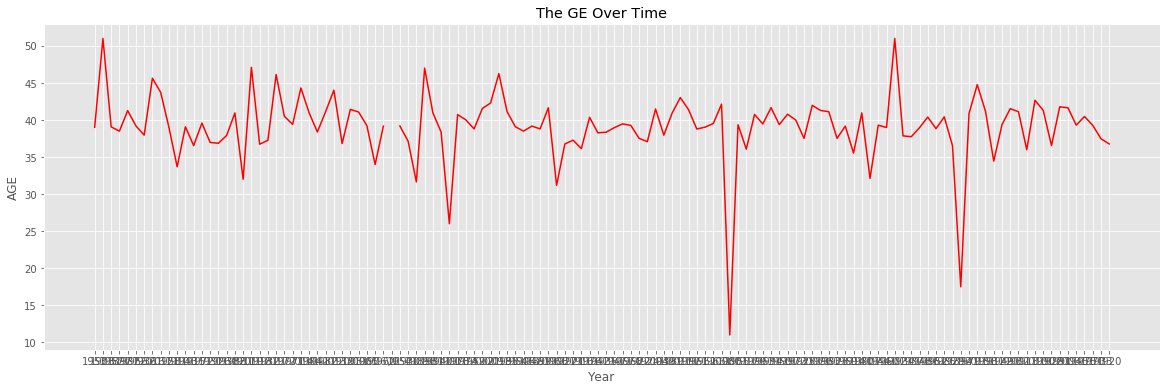

In [70]:
plt.figure(figsize=(20,6))

plt.plot(pd_year_age_df['startYear'],pd_year_age_df['avg(Age)'],color='red')
# plt.plot(pd_year_age_df['startYear'],pd_year_age_df['max(Age)'],color='black')
# plt.plot(pd_year_age_df['startYear'],pd_year_age_df['min(Age)'],color='blue')
# plt.legend(pd_year_age_df['startYear'][0::2,])
plt.xlabel('Year')
plt.ylabel('AGE')
plt.title('The GE Over Time')
plt.show()